In [89]:
import pandas as pd    

df = pd.read_csv('ProductHuntProducts.csv')

In [90]:
df.drop_duplicates(subset='id', keep="first", inplace=True)
# df['target'] = (df['votesCount'] + df['commentsCount']).apply(lambda x: min(x, 1))

# # Check for missing values in description and title
# df.dropna(subset=['description', 'tagline'], inplace=True)
df

,id,name,votesCount,commentsCount,tagline,createdAt,description,topics.totalCount,topics.nodesPieces
0,467006,Pieces Copilot+,432,184,"Remember anything with a real-time, on-device ...",2024-07-10T07:01:00Z,Ask questions about anything on your desktop c...,3,"[{'name': 'Productivity'}, {'name': 'Software ..."
1,466991,Turf,417,187,The in-app community platform for SaaS companies,2024-07-10T07:01:00Z,"Create community forums, customer feedback boa...",3,"[{'name': 'Customer Success'}, {'name': 'SaaS'..."
2,466593,StreamAlive App for Zoom,315,162,Just put it in the chat,2024-07-10T07:01:00Z,"Run polls, quizzes, word clouds, spinner wheel...",3,"[{'name': 'SaaS'}, {'name': 'Remote Work'}, {'..."
3,466672,Flat,230,99,"Simple, delightful, collaborative work tracking",2024-07-10T07:01:00Z,Forget bloated project management tools. Flat ...,3,"[{'name': 'Productivity'}, {'name': 'Task Mana..."
4,469161,Leo,211,73,AI phone assistants,2024-07-10T07:01:00Z,Quickly set up AI phone assistants for making ...,3,"[{'name': 'Artificial Intelligence'}, {'name':..."
...,...,...,...,...,...,...,...,...,...
7168,455400,Dhime,5,3,Learn Dance with AI,2024-05-05T07:01:00Z,"Learn dance anywhere anytime with Dhime, your ...",2,"[{'name': 'Artificial Intelligence'}, {'name':..."
7169,455373,FaceX,2,1,"Face X Anything, become a NPC, or Anime Character",2024-05-05T15:01:00Z,"FaceX, mean's Face X Anything.(Optimization Pa...",3,"[{'name': 'Design Tools'}, {'name': 'Art'}, {'..."
7170,454288,CopyBuddy.io,119,42,Send cold emails your prospects love respondin...,2024-05-05T07:01:00Z,Send cold emails your prospects love respondin...,3,"[{'name': 'Sales'}, {'name': 'Writing'}, {'nam..."
7171,455478,RandCall,2,2,Random Match Chat,2024-05-06T01:49:40Z,Randcall —— Talking & Meeting New People Get t...,3,"[{'name': 'Messaging'}, {'name': 'Video Stream..."


In [13]:
pip install transformers torch scikit-learn

Note: you may need to restart the kernel to use updated packages.


/Users/ivanhusarov/miniconda3/lib/python3.10/site-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


<Axes: ylabel='Frequency'>

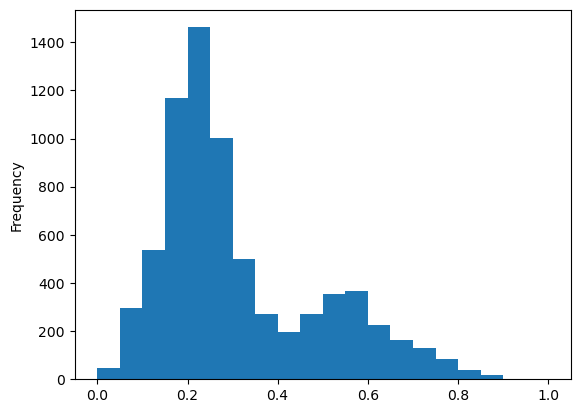

In [91]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt

df['target'] = df['votesCount'] + df['commentsCount']

scaler = MinMaxScaler()
df['target'] = scaler.fit_transform(np.maximum(0, np.log(df[['target']])))

df['target'].plot(kind='hist', bins=20)

In [100]:
df['description'] = df['description'].fillna('na').astype(str).str.lower()
df['tagline'] = df['tagline'].fillna('na').astype(str).str.lower()

In [38]:
import torch
from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Function to get BERT embeddings
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state[:, 0, :]

In [107]:
# get_bert_embedding(df.iloc[3509]['description'])
# df.iloc[[3509]]['description']
# get_bert_embedding("na")
# df['description'] = df.iloc[[3509]]['description'].fillna('').astype(str)

In [111]:
# df.iloc[3509]['description']
# df[['description', 'tagline']]['description']

0       ask questions about anything on your desktop c...
1       create community forums, customer feedback boa...
2       run polls, quizzes, word clouds, spinner wheel...
3       forget bloated project management tools. flat ...
4       quickly set up ai phone assistants for making ...
                              ...                        
7168    learn dance anywhere anytime with dhime, your ...
7169    facex, mean's face x anything.(optimization pa...
7170    send cold emails your prospects love respondin...
7171    randcall —— talking & meeting new people get t...
7172    mtlogin browser offers advanced fingerprint se...
Name: description, Length: 7133, dtype: object

In [126]:
from tqdm import tqdm

# Get embeddings for descriptions and titles
description_embeddings = [get_bert_embedding(desc) for desc in tqdm(df['description'], desc='Tokenizing descriptions', position=0, leave=True)]
tagline_embeddings = [get_bert_embedding(tagline) for tagline in tqdm(df['tagline'], desc='Tokenizing taglines', position=0, leave=True)]

Tokenizing taglines: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7133/7133 [46:12<00:00,  2.57it/s]


In [127]:
# Combine embeddings
embeddings = [torch.cat((desc_emb, tag_emb), dim=1) for desc_emb, tag_emb in zip(description_embeddings, tagline_embeddings)]
embeddings = torch.cat(embeddings, dim=0)

In [148]:
len(tagline_embeddings[0][0])

768

### DistilBERT approach

In [149]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertModel
import pandas as pd
from sklearn.model_selection import train_test_split


class TextDataset(Dataset):
    def __init__(self, descriptions, taglines, targets, tokenizer, max_length):
        self.descriptions = descriptions
        self.taglines = taglines
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self, idx):
        description = str(self.descriptions[idx])
        tagline = str(self.taglines[idx])
        text = description + " " + tagline
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(self.targets[idx], dtype=torch.float)
        }

class DistilBERTClassifier(nn.Module):
    def __init__(self, n_classes):
        super(DistilBERTClassifier, self).__init__()
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.drop = nn.Dropout(p=0.3)
        self.fc = nn.Linear(self.distilbert.config.hidden_size, n_classes)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, input_ids, attention_mask):
        outputs = self.distilbert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = outputs.last_hidden_state[:, 0]  # Use [CLS] token for classification
        output = self.drop(pooled_output)
        output = self.fc(output)
        return self.sigmoid(output)

In [151]:
X_train, X_test, y_train, y_test = train_test_split(
    df[['description', 'tagline']], df['target'], test_size=0.2, random_state=42
)

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
max_length = 512

train_dataset = TextDataset(
    X_train['description'].values, 
    X_train['tagline'].values, 
    y_train.values, 
    tokenizer, 
    max_length
)

test_dataset = TextDataset(
    X_test['description'].values, 
    X_test['tagline'].values, 
    y_test.values, 
    tokenizer, 
    max_length
)


In [153]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Initialize the model, loss function, and optimizer
device = torch.device('mps')
model = DistilBERTClassifier(n_classes=1).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

In [154]:

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['targets'].to(device)
        
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs.squeeze(), targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')


KeyboardInterrupt: 

In [ ]:

# Evaluation
model.eval()
predictions = []
actual = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['targets'].to(device)
        
        outputs = model(input_ids, attention_mask)
        predictions.extend(outputs.cpu().numpy())
        actual.extend(targets.cpu().numpy())

# Calculate accuracy
predictions = [1 if p > 0.5 else 0 for p in predictions]
accuracy = sum([1 if p == a else 0 for p, a in zip(predictions, actual)]) / len(actual)
print(f'Test Accuracy: {accuracy:.4f}')